In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
!pip install missingno
import missingno as msno

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_data.HepG2.Histone.Enhancer.csv')

In [5]:
df

,Pos,gene_name,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
0,chr10:100216834-100995619,HPSE2,0.0,0.0,0.0,5.81644,0.00000,0.0,0.0000,0.0,0.0,1
1,chr10:101156627-101190381,GOT1,0.0,0.0,0.0,3.98603,0.00000,0.0,0.0000,0.0,0.0,1
2,chr10:101542397-101612351,ABCC2,0.0,0.0,0.0,0.00000,0.00000,0.0,7.7407,0.0,0.0,1
3,chr10:101635334-101769704,DNMBP,0.0,0.0,0.0,5.42836,0.00000,0.0,0.0000,0.0,0.0,1
4,chr10:102132856-102213800,OLMALINC,0.0,0.0,0.0,4.81479,3.74003,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,chrX:9217960-9243246,AC003684.1,0.0,0.0,0.0,4.01233,0.00000,0.0,0.0000,0.0,0.0,1
4037,chrX:9983294-10112514,WWC3,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1
4038,chrX:99899192-99930785,SRPX2,0.0,0.0,0.0,0.00000,4.75055,0.0,0.0000,0.0,0.0,1
4039,chrX:9992882-10006694,WWC3-AS1,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1


In [ ]:
msno.matrix(df)

In [ ]:
df.describe()

# Train Random Forest

In [ ]:
df.head()

In [ ]:
df.values

In [ ]:
X = df.values[:,2:-1].astype('float')
y = df.values[:, -1].astype('float')

In [ ]:
y = df.values[:, -1].astype('float')

In [ ]:
X

In [ ]:
y

In [ ]:
np.bincount(y.astype(int))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = list(range(1,30))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# 연속형 범주나 많은 범주를 가진 feature들을 과대평가하는 경향이 있기 때문에 이를 완화시키는 옵션
# mean_impurity_decrease = 0 # float 형태

class_weight = ['balanced', 'balanced_subsample']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}

In [ ]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = 4)
# Fit the random search model
rf_random.fit(xTrain, yTrain)

In [ ]:
rf_random.cv_results_

In [ ]:
rf_random.best_estimator_

In [ ]:
rf_random.best_score_

In [ ]:
rf_random.best_params_

In [ ]:
best_model = rf_random.best_estimator_

# Plot feature importnace

In [ ]:
best_model.feature_importances_

In [ ]:
feature = df.columns[2:-1]

In [ ]:
feature_df = pd.DataFrame(best_model.feature_importances_, columns = ['Value'])
feature_df.index = feature

In [ ]:
feature_df

In [ ]:
feature_df.plot(kind='barh', title = 'Feature importance')

In [ ]:
test_result = best_model.predict(xTest)

In [ ]:
best_model.score(xTest, yTest)

# Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

pred = best_model.predict(xTest)
confusion_matrix(yTest, pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_model, xTest, yTest) 

In [ ]:
best_model.predict_proba(xTest)

In [ ]:
best_model.predict_proba(xTest)[:, 0]

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yTest, best_model.predict_proba(xTest)[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0],
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

metrics.plot_roc_curve(best_model, xTest, yTest)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# Automl로 쉽게 hyperparameter tuning 하기

In [4]:
!pip install -U pycaret

     |████████████████████████████████| 266 kB 4.2 MB/s 
     |████████████████████████████████| 113 kB 37.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 16.9 MB 42 kB/s 
     |████████████████████████████████| 1.7 MB 47.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 271 kB 36.8 MB/s 
     |████████████████████████████████| 261 kB 22.5 MB/s 
     |████████████████████████████████| 2.0 MB 21.5 MB/s 
     |████████████████████████████████| 6.8 MB 47.9 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 167 kB 56.2 MB/s 
     |████████████████████████████████| 1.3 MB 63.7 MB/s 
     |████████████████████████████████| 303 kB 71.5 MB/s 
     |████████████████████████████████| 102 kB 11.8 MB/s 
     |███████████████████

In [6]:
df

,Pos,gene_name,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
0,chr10:100216834-100995619,HPSE2,0.0,0.0,0.0,5.81644,0.00000,0.0,0.0000,0.0,0.0,1
1,chr10:101156627-101190381,GOT1,0.0,0.0,0.0,3.98603,0.00000,0.0,0.0000,0.0,0.0,1
2,chr10:101542397-101612351,ABCC2,0.0,0.0,0.0,0.00000,0.00000,0.0,7.7407,0.0,0.0,1
3,chr10:101635334-101769704,DNMBP,0.0,0.0,0.0,5.42836,0.00000,0.0,0.0000,0.0,0.0,1
4,chr10:102132856-102213800,OLMALINC,0.0,0.0,0.0,4.81479,3.74003,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,chrX:9217960-9243246,AC003684.1,0.0,0.0,0.0,4.01233,0.00000,0.0,0.0000,0.0,0.0,1
4037,chrX:9983294-10112514,WWC3,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1
4038,chrX:99899192-99930785,SRPX2,0.0,0.0,0.0,0.00000,4.75055,0.0,0.0000,0.0,0.0,1
4039,chrX:9992882-10006694,WWC3-AS1,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1


In [7]:
df['enhancer'] = df['enhancer'].astype('int') # enhancer 열을 int type으로 변환.

In [8]:
import pycaret
pycaret.__version__

'2.3.4'

In [9]:
from pycaret.classification import * # pycaret의 classification을 import하고

# clf1이라는 객체를 다음 arg를 넣어서 초기화.
clf1 = setup(data = df, target = 'enhancer', ignore_features = ['Pos','gene_name'], session_id=123)

,Description,Value
0,session_id,123
1,Target,enhancer
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4041, 12)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [10]:
# check the model library to see all models 
models() # automl로 학습할 수 있는 모델은 이런것들이 있다~

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [11]:
# train rf model using 5 fold CV # Random Forest Classifier를 생성.
rf = create_model('rf', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0,0.0,1.0,1.0,1.0,NaN,0.0
1,1.0,0.0,1.0,1.0,1.0,NaN,0.0
2,1.0,0.0,1.0,1.0,1.0,NaN,0.0
3,1.0,0.0,1.0,1.0,1.0,NaN,0.0
4,1.0,0.0,1.0,1.0,1.0,NaN,0.0
Mean,1.0,0.0,1.0,1.0,1.0,NaN,0.0
SD,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [12]:
tuned_rf = tune_model(rf) # 모델의 최적값의 parameter들을 찾아줌.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0,0.0,1.0,1.0,1.0,NaN,0.0
1,1.0,0.0,1.0,1.0,1.0,NaN,0.0
2,1.0,0.0,1.0,1.0,1.0,NaN,0.0
3,1.0,0.0,1.0,1.0,1.0,NaN,0.0
4,1.0,0.0,1.0,1.0,1.0,NaN,0.0
5,1.0,0.0,1.0,1.0,1.0,NaN,0.0
6,1.0,0.0,1.0,1.0,1.0,NaN,0.0
7,1.0,0.0,1.0,1.0,1.0,NaN,0.0
8,1.0,0.0,1.0,1.0,1.0,NaN,0.0
9,1.0,0.0,1.0,1.0,1.0,NaN,0.0


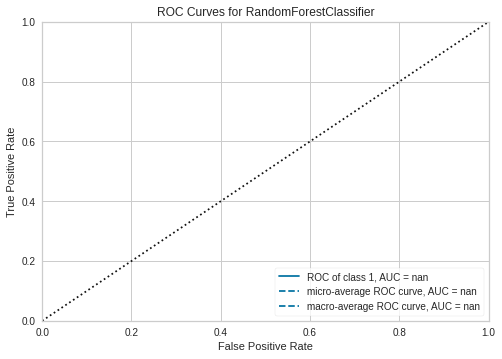

In [13]:
plot_model(tuned_rf, plot = 'auc') # AUC를 그려봄.

In [14]:
plot_model(tuned_rf, plot = 'pr')

IntProgress(value=0, description='Processing: ', max=5)

IndexError: ignored

<Figure size 576x396 with 0 Axes>

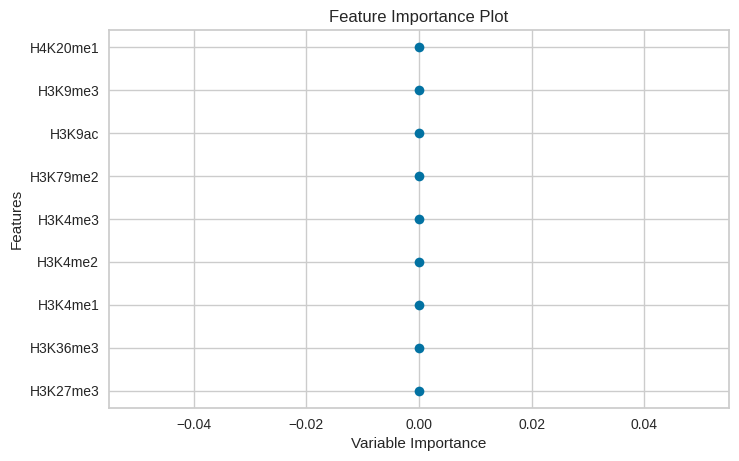

In [15]:
plot_model(tuned_rf, plot='feature')

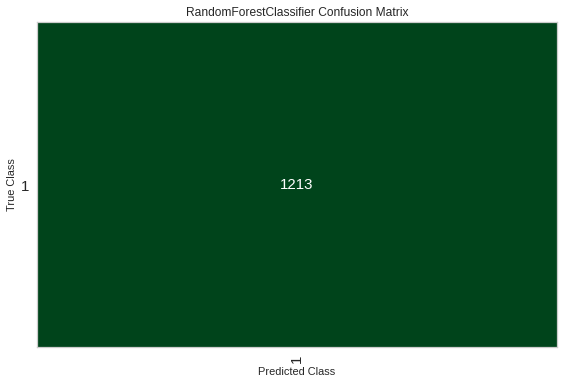

In [16]:
plot_model(tuned_rf, plot = 'confusion_matrix')

In [17]:
evaluate_model(tuned_rf) # 내용을 클릭해서 관련 사항을 확인할 수 있음.

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<Figure size 576x396 with 0 Axes>

In [18]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.125
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.018
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.279
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.023
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.263
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.057


XgBoost 사용해보기.

In [19]:
!pip install xgboost

In [20]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [21]:
df

,Pos,gene_name,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
0,chr10:100216834-100995619,HPSE2,0.0,0.0,0.0,5.81644,0.00000,0.0,0.0000,0.0,0.0,1
1,chr10:101156627-101190381,GOT1,0.0,0.0,0.0,3.98603,0.00000,0.0,0.0000,0.0,0.0,1
2,chr10:101542397-101612351,ABCC2,0.0,0.0,0.0,0.00000,0.00000,0.0,7.7407,0.0,0.0,1
3,chr10:101635334-101769704,DNMBP,0.0,0.0,0.0,5.42836,0.00000,0.0,0.0000,0.0,0.0,1
4,chr10:102132856-102213800,OLMALINC,0.0,0.0,0.0,4.81479,3.74003,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,chrX:9217960-9243246,AC003684.1,0.0,0.0,0.0,4.01233,0.00000,0.0,0.0000,0.0,0.0,1
4037,chrX:9983294-10112514,WWC3,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1
4038,chrX:99899192-99930785,SRPX2,0.0,0.0,0.0,0.00000,4.75055,0.0,0.0000,0.0,0.0,1
4039,chrX:9992882-10006694,WWC3-AS1,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1


In [22]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 400

In [23]:
X = df.values[:,2:-1].astype('float')
y = df.values[:, -1].astype('float')

In [24]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)

In [25]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=xTrain, label = yTrain)
dtest = xgb.DMatrix(data=xTest, label=yTest)

In [26]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-logloss:0.598254	eval-logloss:0.598251
[1]	train-logloss:0.520509	eval-logloss:0.520512
[2]	train-logloss:0.455684	eval-logloss:0.455677
[3]	train-logloss:0.400873	eval-logloss:0.400865
[4]	train-logloss:0.354039	eval-logloss:0.35404
[5]	train-logloss:0.313692	eval-logloss:0.313698
[6]	train-logloss:0.278709	eval-logloss:0.278704
[7]	train-logloss:0.248179	eval-logloss:0.248184
[8]	train-logloss:0.221435	eval-logloss:0.221435
[9]	train-logloss:0.197903	eval-logloss:0.197899
[10]	train-logloss:0.177124	eval-logloss:0.177123
[11]	train-logloss:0.158726	eval-logloss:0.158729
[12]	train-logloss:0.142399	eval-logloss:0.142402
[13]	train-logloss:0.127879	eval-logloss:0.127877
[14]	train-logloss:0.114934	eval-logloss:0.114936
[15]	train-logloss:0.10338	eval-logloss:0.103382
[16]	train-logloss:0.093053	eval-logloss:0.093053
[17]	train-logloss:0.083808	eval-logloss:0.083808
[18]	train-logloss:0.075523	eval-logloss:0.075523
[19]	train-logloss:0.068092	eval-logloss:0.068091
[20]	train-l

In [27]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
예측값 10개만 표시:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [28]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [29]:
get_clf_eval(yTest, preds)

ValueError: ignored

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)